# **Image Segmentation**
Image segmentation is the task of assigning a label or class to each individual pixel of an image. Image segmentation has many applications in medical imaging, self-driving cars and satellite imaging, just to name a few.

We shall use a modified U-Net model for image segmentation. U-Net consists of an encoder (downsampler) and a decoder (upsampler) with skip connections. We shall use a pretrained MobileNet V2 model as the encoder and upsample layers from pix2pix example in the TensorFlow examples repo as the decoder.

### **1. Install and Import Required Libraries**

In [ ]:
!pip install git+https://github.com/tensorflow/examples.git

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras import layers
from tensorflow_examples.models.pix2pix import pix2pix
from IPython.display import clear_output

### **2. Load Data**

In [ ]:
img_height = 128
img_width = 128
batch_size = 64
buffer_size = 1000
output_classes = 3
num_epochs = 20

In [ ]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

### **3. Preprocess Data**

In [ ]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1 # converting segmentation masks from {1, 2, 3} to {0, 1, 2}
  return input_image, input_mask

def load_image(datapoint):
  input_image = tf.image.resize(datapoint['image'], size=(img_height, img_width))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], size=(img_height, img_width), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  input_image, input_mask = normalize(input_image, input_mask)
  return input_image, input_mask

In [ ]:
train_images = dataset['train'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images = dataset['test'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
class Augment(layers.Layer):

  def __init__(self, seed=44):
    super().__init__()
    self.augment_inputs = layers.RandomFlip(mode='horizontal', seed=seed)
    self.augment_labels = layers.RandomFlip(mode='horizontal', seed=seed)

  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels

In [ ]:
train_batches = (
    train_images
    .cache()
    .shuffle(buffer_size)
    .batch(batch_size=batch_size)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

test_batches = test_images.batch(batch_size=batch_size)

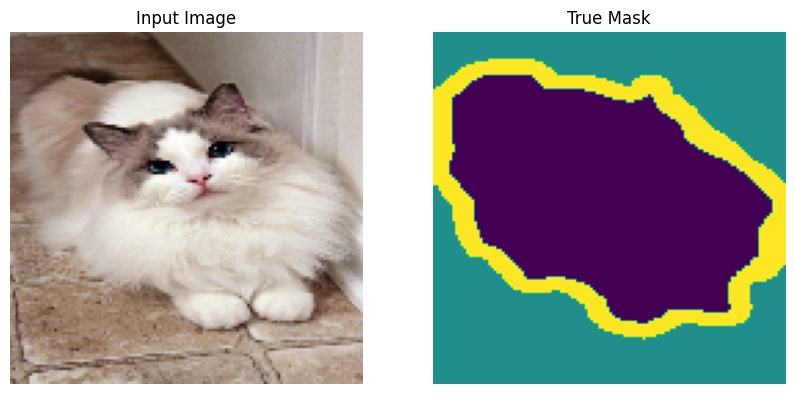

In [ ]:
def display(display_list):
  plt.figure(figsize=(10, 10))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i, item in enumerate(display_list):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(item))
    plt.axis('off')
  plt.show()

images, masks = next(iter(train_batches))
sample_image = images[0]
sample_mask = masks[0]

display([sample_image, sample_mask])

### **4. Create Model**

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[img_height, img_width, 3], include_top=False)

layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project'       # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)
down_stack.trainable = False

In [ ]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4   -> 8x8
    pix2pix.upsample(256, 3),  # 8x8   -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3)    # 32x32 -> 64x64
]

In [ ]:
def unet_model(output_channels):
  inputs = layers.Input(shape=[img_height, img_width, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = layers.Concatenate()([x, skip])

  last = layers.Conv2DTranspose(filters=output_channels, kernel_size=3, strides=2, padding='same')  # 64x64 -> 128x128

  outputs = last(x)

  return tf.keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model = unet_model(output_channels=output_classes)
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

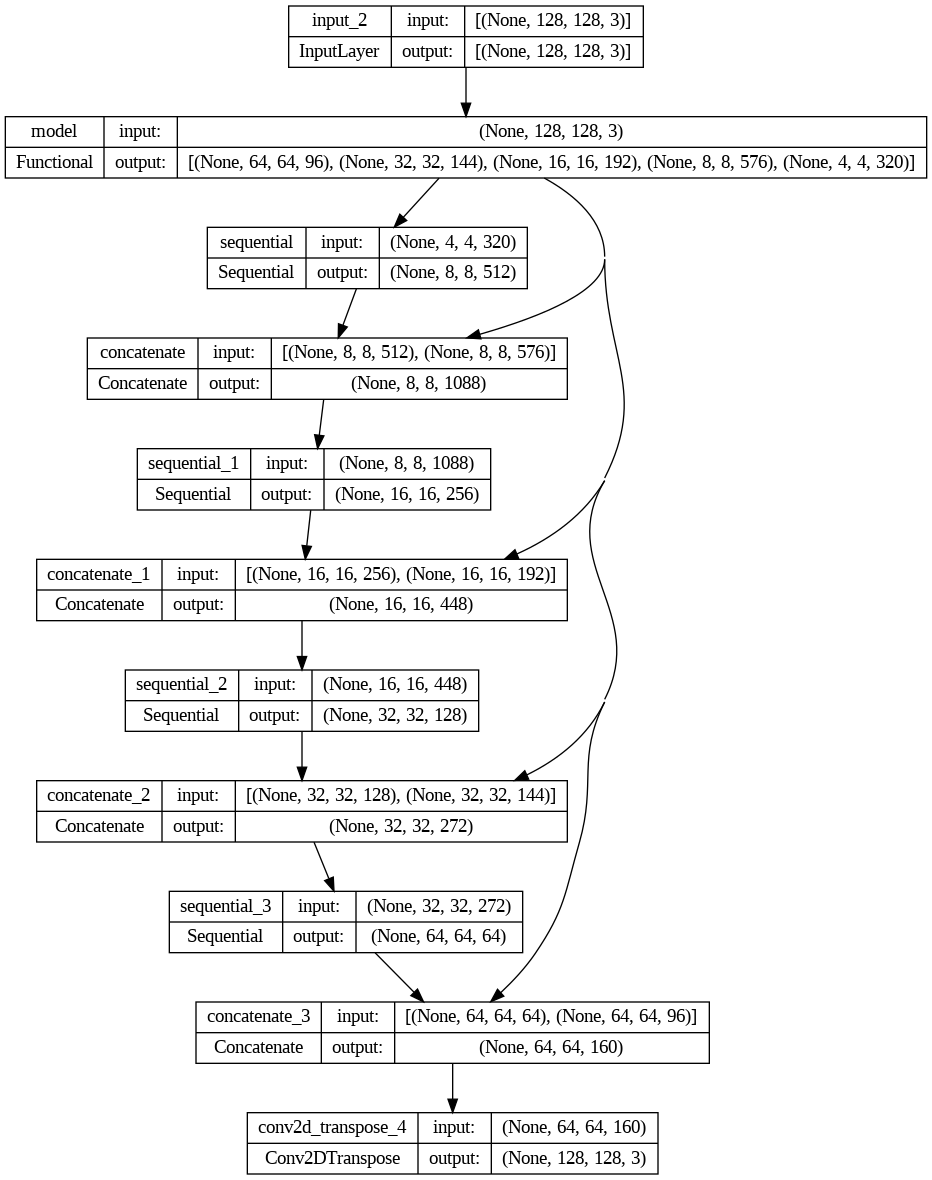

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

### **5. Predict using the Model before training**

In [ ]:
def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.skip(4).take(num):
      pred = model.predict(image)
      pred_mask = create_mask(pred)
      display([image[0], mask[0], pred_mask])
  else:
    pred = model.predict(sample_image[tf.newaxis, ...])
    pred_mask = create_mask(pred)
    display([sample_image, sample_mask, pred_mask])

2/2 [==============================] - 5s 21ms/step


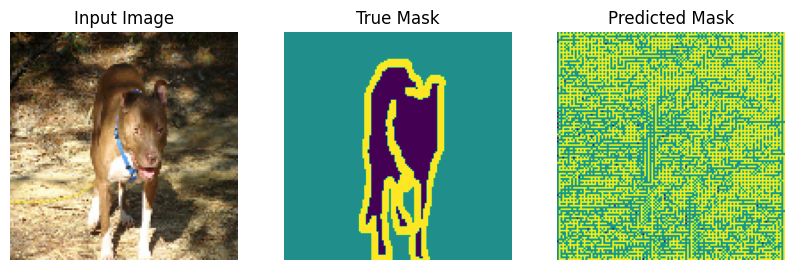

In [ ]:
show_predictions(test_batches, 1)

### **6. Train the Model**

In [ ]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print(f"\nSample prediction after epoch {epoch+1}\n")

1/1 [==============================] - 0s 24ms/step


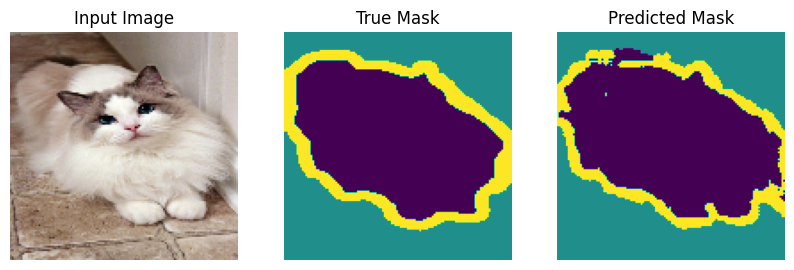


Sample prediction after epoch 20

57/57 [==============================] - 10s 172ms/step - loss: 0.1717 - accuracy: 0.9300 - val_loss: 0.2657 - val_accuracy: 0.9050


In [ ]:
train_length = info.splits['train'].num_examples
steps_per_epoch = train_length // batch_size
val_subsplits = 5
validation_steps = info.splits['test'].num_examples // batch_size // val_subsplits

history = model.fit(
    train_batches,
    validation_data=test_batches,
    epochs=num_epochs,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[DisplayCallback()]
)

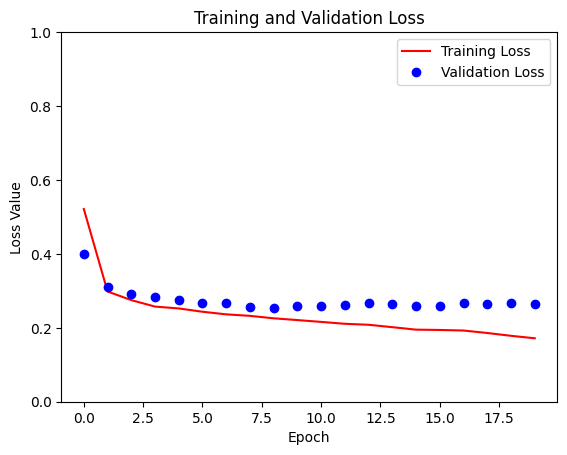

In [ ]:
loss = history.history['loss']
validation_loss = history.history['val_loss']

plt.figure()
plt.plot(history.epoch, loss, 'r', label='Training Loss')
plt.plot(history.epoch, validation_loss, 'bo', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

### **7. Predict using the Model after training**

2/2 [==============================] - 0s 41ms/step


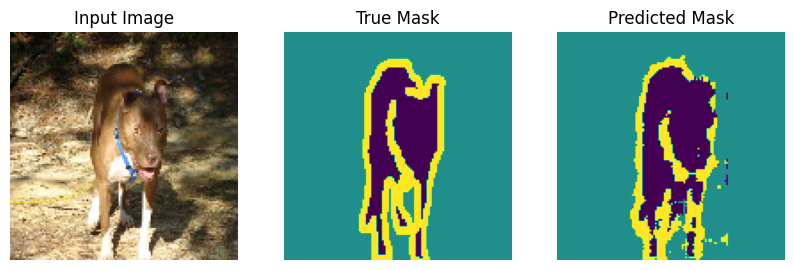

In [ ]:
show_predictions(test_batches, 1)

### **8. Handle Imbalanced Classes using Class Weights**

In [ ]:
# Model.fit does not support class_weight argument for targets with 3+ dimensions to avoid ambiquity
# In case of 3+ dimensions, instead of passing dataset in (data, label) format to model.fit, it should be passsed as (data, label, sample_weight)
def add_sample_weights(image, label):
  class_weights = tf.constant([2.0, 2.0, 1.0])
  # Rescaling class_weights as total of all class weights should be 1.0
  class_weights = class_weights / tf.reduce_sum(class_weights)

  sample_weights = tf.gather(class_weights, indices=tf.cast(label, tf.int32))

  return image, label, sample_weights

In [ ]:
train_batches.map(add_sample_weights).element_spec

(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None))

In [ ]:
model = unet_model(output_classes)
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

history = model.fit(
    train_batches.map(add_sample_weights),
    epochs=num_epochs,
    steps_per_epoch=steps_per_epoch
)

Epoch 1/20
57/57 [==============================] - 12s 120ms/step - loss: 0.1348 - accuracy: 0.8347
Epoch 2/20
57/57 [==============================] - 6s 114ms/step - loss: 0.0606 - accuracy: 0.9148
Epoch 3/20
57/57 [==============================] - 7s 115ms/step - loss: 0.0517 - accuracy: 0.9247
Epoch 4/20
57/57 [==============================] - 7s 115ms/step - loss: 0.0489 - accuracy: 0.9273
Epoch 5/20
57/57 [==============================] - 7s 116ms/step - loss: 0.0463 - accuracy: 0.9300
Epoch 6/20
57/57 [==============================] - 7s 116ms/step - loss: 0.0452 - accuracy: 0.9313
Epoch 7/20
57/57 [==============================] - 7s 117ms/step - loss: 0.0442 - accuracy: 0.9323
Epoch 8/20
57/57 [==============================] - 7s 119ms/step - loss: 0.0423 - accuracy: 0.9349
Epoch 9/20
57/57 [==============================] - 7s 117ms/step - loss: 0.0409 - accuracy: 0.9364
Epoch 10/20
57/57 [==============================] - 7s 121ms/step - loss: 0.0393 - accuracy: 0.938

2/2 [==============================] - 1s 42ms/step


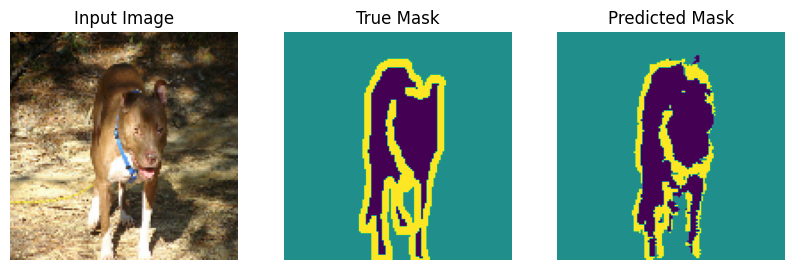

In [ ]:
show_predictions(test_batches, 1)